In [1]:
import networks as nt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})
plt.rcParams.update({'font.size': 10, 'font.family': 'Helvetica'})

In [2]:
ignore_resets = True

In [3]:
s_mag = 5.2
signal_noise = 0.01
reset = 0
threshold = 1
lambd = 2
ref_t = 0
noise = 0.02
time_r = 0.6
time_c = 2
dt = 2e-5
seed = 1
np.random.seed(seed)
marker_size = 1
m_alpha = 0.01

In [4]:
T_r = int(time_r / dt)
T_c = int(time_c / dt)

In [5]:
def sim_current(F, Omega, Th, X, dt, dV, lambd, R0, V0, ref_t=0.003, seed=1):
    '''
    Inputs: 
        F: (N, M) array. Encoding Weights. N is the number of neurons and M is the signal dimension
        Omega: (N, N) array. Recurrent Connections. N is the number of neurons
        Th: (N,) array. Neuron Thresholds. N is the number of neurons
        X: (T, M) array. Signal to be represented. T is the number of time steps and M is the signal dimension
        dt: scalar. Time step of the simulation
        dV: (T, N) array. Additive term on the voltages traces (should already be multiplied by the time step)
        lambd: positive scalar. Decoder time constant
        R0: (N,) array. Initial Rate Values
        V0: (N,) array. Initial Voltage values
        ref_t: non-negative scalar. refractory period duration in seconds
    Outputs:
        R: ((T + jump - 1) // jump, N) array. Firing Rates approximation of each neuron. T is the number of time steps and N is the number of neurons
        Spikes: list of lists. Each element in Spikes is a list containing the simulation time where that neuron fired
        Rn: (N,) array. Final Rates of the simulation
        Vn: (N,) array. Final Voltages of the simulation
    '''
    np.random.seed(seed)
    ref = max(int(np.ceil(ref_t / dt)), 1) # minimum number of time steps between same-neuron spikes
    dtlamb = 1 - dt * lambd
    N = F.shape[0]  # N is the number of Neurons
    T = X.shape[0]  # T is the total time iterations
    Vc = V0.copy() # Array with the current Voltages
    Rc = R0.copy() # Array with the current Rates
    R = np.zeros((T, N))  # Array with the approximation of the firing rates
    Spikes = [[] for i in range(N)]  # list of lenght Neurons of list of lenght no_spikes
    FX = np.dot(X, F.T)  # Network inputs
    Ref = -1 * np.ones(N)
    Th_c = Th
    saturation = np.zeros(N)
    BAL = np.zeros((T, N, 2))
    FF = np.zeros((T, N))
    REC = np.zeros((T, N))
    SELF = np.zeros((T, N))
    for i in range(T):
        # SN is a list containing neurons that should fire
        VR = ((Vc > Th_c) & (Ref <= 0))
        while np.any(VR):
            SN = np.where(VR)[0]
            SNN = np.where(Vc[SN] == np.max(Vc[SN]))[0]
            sn = SN[np.random.choice(SNN)]
            Rc[sn] += 1
            Spikes[sn].append(i)
            Ref[sn] = ref
            # Adding the resets of each spike through Omega
            Vc -= Omega[:, sn]
            BAL[i, :, 0] += np.minimum(-Omega[:, sn], 0)
            REC[i, :] -= Omega[:, sn]
            REC[i, sn] += Omega[sn, sn]
            SELF[i, sn] -= Omega[sn, sn]
            if ignore_resets:
                BAL[i, sn, 0] += Omega[sn, sn]
            BAL[i, :, 1] += np.maximum(-Omega[:, sn], 0)
            VR = ((Vc > Th_c) & (Ref <= 0))
        if np.any(Vc > Th_c):
            for j in range(N):
                if Vc[j] > Th_c[j]:
                    saturation[j] += 1
        Rc *= dtlamb
        Vc = dtlamb * Vc + dt * FX[i, :] + dV[i, :]
        FF[i, :] = dt * FX[i, :] + dV[i, :]
        BAL[i, :, 0] += np.minimum(dt * FX[i, :], 0)
        BAL[i, :, 1] += np.maximum(dt * FX[i, :], 0)
        Ref -= 1
        R[i, :] = Rc
    print('dt', dt, 'ref', ref, 'delay', 0, 'N', N, 'most saturated neuron: ', np.max(saturation) / T, 'average saturated neuron:', np.mean(saturation) / T)
    return R, Spikes, BAL, FF, REC, SELF, Rc, Vc

In [6]:
def plot(neuron2plot, ll, ul, min_psp='', max_psp=''):
    color_sr = '#bcdbb2'
    color_ff = '#c83839'
    color_rec = '#6a99cc'
    dashes = [0.5, 0.5]
    lw = 0.5
    if min_psp == '':
        zorder = [1, 2, 3, 4, 5, 6]
    else:
        zorder = [4, 2, 1, 5, 6, 3]
    scale = 0.31
    no_plots = 4
    fig, ax = plt.subplots(no_plots, 1, figsize=(scale * 6, scale * 1.5 * (no_plots + 3)), gridspec_kw={'height_ratios': [1, 1, 1, 4]})

    ax_raster = ax[0]
    ax_ind = ax[1]
    ax_psp = ax[2]
    ax_bb = ax[3]

    no_spn = len(spiking_neurons)
    for i, sn in enumerate(spiking_neurons):
        array_spikes = Spikes[sn]
        if sn == neuron2plot:
            ax_raster.plot(array_spikes, i * np.ones(len(array_spikes)), '|', color=color_sr, markersize=2)
        else:
            ax_raster.plot(array_spikes, i * np.ones(len(array_spikes)), '|', color='black', markersize=2)
    ax_raster.set_ylim([-0.5, no_spn - 0.5])
    ax_raster.set_xlim([15000, FF.shape[0] + 1])
    ax_raster.set_xticks([])
    ax_raster.set_yticks([])
    ax_raster.spines['right'].set_visible(False)
    ax_raster.spines['top'].set_visible(False)
    ax_raster.spines['left'].set_visible(False)
    ax_raster.spines['bottom'].set_visible(False)

    filter_exp = np.exp(-0.1 * np.linspace(0, 40, 20000))
    filter_exp /= np.sum(filter_exp)
    rec = np.convolve(REC[:, neuron2plot], filter_exp)[:T_c]
    sr = np.convolve(SELF[:, neuron2plot], filter_exp)[:T_c]
    ffff = np.convolve(FF[:, neuron2plot], filter_exp)[:T_c]

    ax_ind.plot(sr, color=color_sr, dashes=dashes, zorder = zorder[3], lw=lw)
    ax_ind.plot(ffff, color=color_ff, dashes=dashes, zorder = zorder[4], lw=lw)
    ax_ind.plot(rec, color=color_rec, dashes=dashes, zorder = zorder[5], lw=lw)
    ax_ind.set_xlim([15000, FF.shape[0] + 1])
    ax_ind.set_xticks([])
    ax_ind.set_yticks([0])
    if min_psp == '':
        ax_ind.yaxis.tick_right()
    ax_ind.axhline(color='black', lw=2/3)
    ax_ind.spines['right'].set_visible(False)
    ax_ind.spines['top'].set_visible(False)
    ax_ind.spines['left'].set_visible(False)
    ax_ind.spines['bottom'].set_visible(False)

    PSP = ffff + rec
    filter_exp_large = np.exp(-np.linspace(0, 10, 100000))
    filter_exp_large /= 1000
    PSP_f = np.convolve(PSP, filter_exp_large)[:T_c]
    
    ax_psp.plot(PSP_f, dashes=dashes, lw=lw)
    ax_psp.axhline(color='black', lw=2/3)
    
    if min_psp == '':
        ax_psp.yaxis.tick_right()
    if min_psp == '':
        min_psp = np.min(PSP) - 0.001
    if max_psp == '':
        max_psp = np.max(PSP_f) + 0.001
    ax_psp.set_ylim([min_psp, max_psp])
    ax_psp.set_xlim([15000, FF.shape[0] + 1])
    ax_psp.set_xticks([])
    ax_psp.set_yticks([0])
    ax_psp.spines['right'].set_visible(False)
    ax_psp.spines['top'].set_visible(False)
    ax_psp.spines['left'].set_visible(False)
    ax_psp.spines['bottom'].set_visible(False)


    ax_bb.plot(Xh_c[ll:ul, 0], Xh_c[ll:ul, 1])
    ax_bb.plot(Xh_c[ll, 0], Xh_c[ll, 1], '.')
    ax_bb.plot(X[0, 0], X[0, 1], '+')
    if N == 5:
        for i in range(N):
            c_p = X[0, :] - threshold * F[i, :]
            ax_bb.plot(c_p[0] + np.array([-1, 1]) * F[i, 1], c_p[1] - np.array([-1, 1]) * F[i, 0])
    else:
        for i in [50, 150, 250, 350]:
            c_p = X[0, :] - threshold * F[i, :]
            ax_bb.plot(c_p[0] + np.array([-1, 1]) * F[i, 1], c_p[1] - np.array([-1, 1]) * F[i, 0])
        for i in spiking_neurons:
            c_p = X[0, :] - threshold * F[i, :]
            ax_bb.plot(c_p[0] + np.array([-1, 1]) * F[i, 1], c_p[1] - np.array([-1, 1]) * F[i, 0])
    ax_bb.spines['right'].set_visible(False)
    ax_bb.spines['top'].set_visible(False)
    ax_bb.spines['left'].set_visible(False)
    ax_bb.spines['bottom'].set_visible(False)
    ax_bb.set_xticks([])
    ax_bb.set_yticks([])
    
    ax_bb.set_xlabel('$x_1$')
    ax_bb.set_ylabel('$x_2$')
    ax_bb.set_aspect('equal')

    fig.tight_layout(rect=[0, 0, 1, 1])
    if ul == 40000:
        letter = 'B'
    else:
        letter = 'C'
    fig.savefig('FIG4{}.pdf'.format(letter))
    return min_psp, max_psp

In [7]:
N = 5
angles = np.linspace(0, 2 * np.pi, num = N + 1) + np.pi
D = np.zeros((2, N))
D[0, :] = np.cos(angles[:-1])
D[1, :] = np.sin(angles[:-1])
F = D.copy().T
Omega = np.dot(D.T, D)
for i in range(N):
    Omega[i, i] *= 2 ** reset
Th = threshold * np.ones(N)

angle = 2 * np.pi / 15
x = s_mag * np.array([np.cos(angle), np.sin(angle)])
X_r = np.outer(np.linspace(0, 1, T_r + 1), x)
C_r = np.diff(X_r.T).T / dt
X_r = X_r[:-1, :]

In [8]:
C_r += lambd * X_r
dV_r = np.sqrt(dt) * noise * np.random.randn(T_r, N)
R_r, Spikes_r, BAL_r, FF_r, REC_r, SELF_r, R0, V0 = sim_current(F, Omega, Th, C_r, dt, dV_r, lambd, np.zeros(N), np.zeros(N), ref_t=ref_t, seed=seed)
Xh_r = np.dot(R_r, D.T)

X = nt.constant_signal(x, T_c, dt, signal_noise=signal_noise, seed=seed)
C = lambd * X
dV = np.sqrt(dt) * noise * np.random.randn(T_c, N)
R, Spikes, BAL, FF, REC, SELF, R0, V0 = sim_current(F, Omega, Th, C, dt, dV, lambd, R0, V0, ref_t=ref_t, seed=seed)

spiking_neurons = [i for i in range(N) if len(Spikes[i])>0]

Xh_c = np.dot(R, D.T)

dt 2e-05 ref 1 delay 0 N 5 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 2e-05 ref 1 delay 0 N 5 most saturated neuron:  0.0 average saturated neuron: 0.0


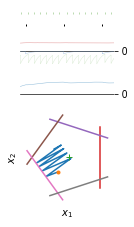

In [9]:
min_psp, max_psp = plot(3, 20000, 40000)

In [10]:
angle = np.pi * 8 / 16
angle = np.pi * 12 / 16
x = s_mag * np.array([np.cos(angle), np.sin(angle)])
X_r = np.outer(np.linspace(0, 1, T_r + 1), x)
C_r = np.diff(X_r.T).T / dt
X_r = X_r[:-1, :]
C_r += lambd * X_r

threshold = 1
N = 600
F, Omega, Th, D = nt.create_param(2, N, threshold=threshold, reset=reset, seed_network=seed, regular=True)
dV_r = np.sqrt(dt) * noise * np.random.randn(T_r, N)
R_r, Spikes_r, BAL_r, FF_r, REC_r, SELF_r, R0, V0 = sim_current(F, Omega, Th, C_r, dt, dV_r, lambd, np.zeros(N), np.zeros(N), ref_t=ref_t, seed=seed)
Xh_r = np.dot(R_r, D.T)


X = nt.constant_signal(x, T_c, dt, signal_noise=signal_noise, seed=seed)
C = lambd * X
dV = np.sqrt(dt) * noise * np.random.randn(T_c, N)
R, Spikes, BAL, FF, REC, SELF, R0, V0 = sim_current(F, Omega, Th, C, dt, dV, lambd, R0, V0, ref_t=ref_t, seed=seed)

spiking_neurons = [i for i in range(N) if len(Spikes[i])>0]

Xh_c = np.dot(R, D.T)

dt 2e-05 ref 1 delay 0 N 600 most saturated neuron:  0.0 average saturated neuron: 0.0
dt 2e-05 ref 1 delay 0 N 600 most saturated neuron:  0.0 average saturated neuron: 0.0


(-0.0009999410021526856, 0.0030121970053980287)

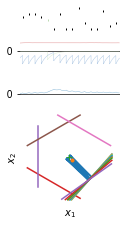

In [11]:
plot(spiking_neurons[3], 50000, 75000, min_psp, max_psp)